## Setup

### Imports

In [11]:
import torch
import matplotlib.pyplot as plt
from datetime import datetime

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils
from stocksense.api import data as api_data

In [12]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

### Data

In [13]:
msft_df_train = await api_data.get_kline_df('yfinance', 'MSFT', datetime(2000, 1, 1), datetime(2022, 12, 31), '1d')
aapl_df_train = await api_data.get_kline_df('yfinance', 'AAPL', datetime(2000, 1, 1), datetime(2022, 12, 31), '1d')
dfs_train = [msft_df_train, aapl_df_train]

print(msft_df_train.shape)
print(aapl_df_train.shape)

msft_df_test = await api_data.get_kline_df('yfinance', 'MSFT', datetime(2023, 1, 1), datetime(2024, 12, 1), '1d')
aapl_df_test = await api_data.get_kline_df('yfinance', 'AAPL', datetime(2023, 1, 1), datetime(2024, 12, 1), '1d')
dfs_test = [msft_df_test, aapl_df_test]

print(msft_df_test.shape)
print(aapl_df_test.shape)

(5787, 6)
(5787, 6)
(481, 6)
(481, 6)


### Environment

In [14]:
env_kwargs = {
    'trading_fees': 0.01/100,
    'windows': 5
}
env = scenv.MultiStockTradingEnv(name= "MY_ENV", dfs=dfs_train, **env_kwargs)
env_for_buy_and_hold = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_BUY_AND_HOLD", dfs=dfs_test, strategy='buy_and_hold', **env_kwargs)
env_test = scenv.MultiStockTradingEnv(name= "MY_ENV_TEST", dfs=dfs_test, **env_kwargs)

## Baseline: Random Agent

In [15]:
done, truncated = False, False
observation, info = env_test.reset()
while not done and not truncated:
    position_index = env_test.action_space.sample()
    observation, reward, done, truncated, info = env_test.step(position_index)
history_random = env_test.get_history()

Portfolio Return : 23.52%


## Baseline: Buy and Hold

In [16]:
done, truncated = False, False
observation, info = env_for_buy_and_hold.reset()
while not done and not truncated:
    position_index = [0, 1, 0]
    observation, reward, done, truncated, info = env_for_buy_and_hold.step(position_index)
history_buy_and_hold = env_for_buy_and_hold.get_history()

Portfolio Return : 30.34%


## Agent: DQN

### Build Agent

In [17]:
policy_kwargs = {
    'net_arch': [128, 128]
}
hparas = {
    'batch_size': 128,
    'gamma': 0.99,
    'exploration_initial_eps': 0.9,
    'exploration_final_eps': 0.05,
    'exploration_fraction': 0.001,
    'target_update_interval': 10000,
    'learning_rate': 1e-4,
    'buffer_size': 10000,
    'policy_kwargs': policy_kwargs,
    'tensorboard_log': 'dqn_tensorboard'
}

In [18]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 8)
model.save("dqn")

model = DQN.load("dqn")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_dqn = env_test.get_history()

Portfolio Return : 472.96%
Portfolio Return : 2748.94%
Portfolio Return : 2522.24%
Portfolio Return : 12768.35%
Portfolio Return : 4786.98%
Portfolio Return : 34871.30%
Portfolio Return : 4700.46%
Portfolio Return : 34649.53%
predicting...
Portfolio Return : 62.68%


## Agent: A2C

In [21]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 5)
model.save("a2c")

model = A2C.load("a2c", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_a2c = env_test.get_history()

Portfolio Return : -35.93%
Portfolio Return : 88.62%
Portfolio Return : 29.61%
Portfolio Return : 236.29%
Portfolio Return : 502.80%
predicting...
Portfolio Return : 77.81%


### Visualization

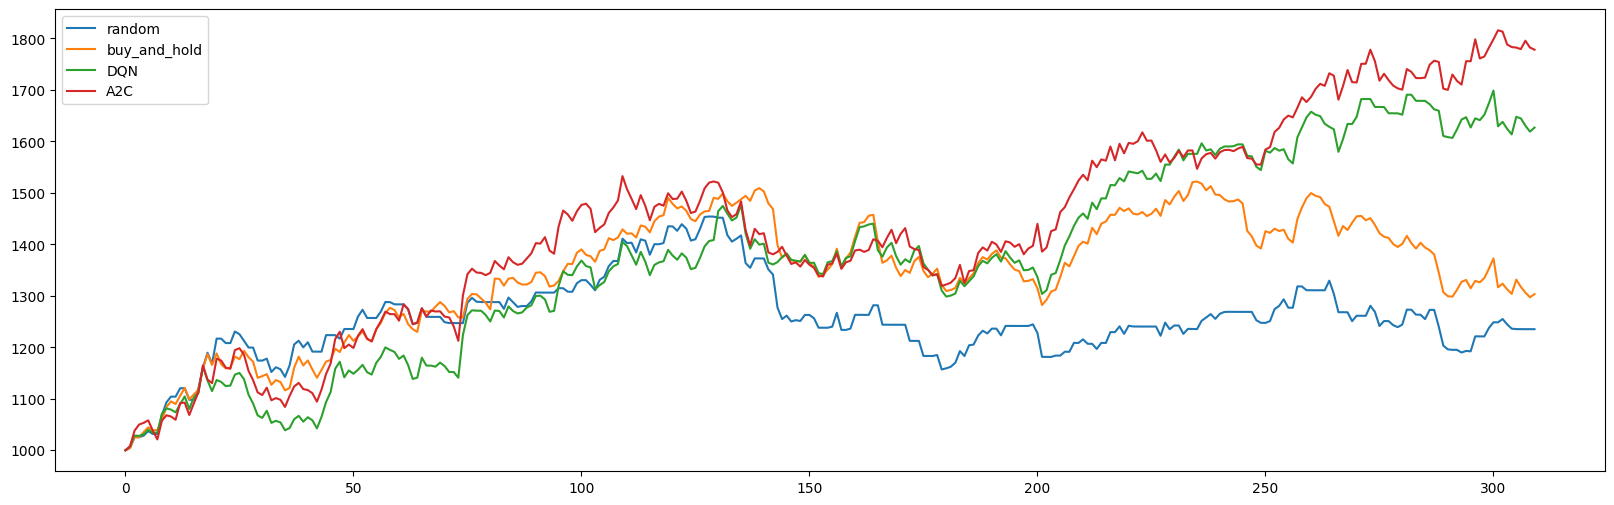

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(history_random, label="random")
plt.plot(history_buy_and_hold, label="buy_and_hold")
plt.plot(history_dqn, label="DQN")
plt.plot(history_a2c, label="A2C")
plt.legend()
plt.show()